# Stack Development

We know that L = 4 reconstructs well with ternary r and predicted inputs.

The VPUWrapper is similar to our original stage - we now need to merge these.

We can start with audio data - 256 is a power of 4.

In [1]:
import numpy as np
import math

In [2]:
256**(1/4)

4.0

In [3]:
math.log(256, 4)

4.0

In [43]:
from src.var_processor.vpu import VPUBinaryZM

class Stage:
    """Object to represent a stage of processing."""

    def __init__(self, vec_len, stage_len):
        """Initialise stage.

        Arg:
            vec_len - length of each 1D vector processed by the VPUs.
            stage_len - integer indicating number of VPUs.
        """
        self.vec_len = vec_len
        self.stage_len = stage_len
        self.size = self.vec_len*self.stage_len
        self.vpus = [VPUBinaryZM(vec_len) for _ in range(0, stage_len)]
        # Create a blank array for the causes
        self.causes = np.zeros(shape=(stage_len, 1))
        # Create a blank array for the predicted inputs
        self.pred_inputs = np.zeros(shape=(self.size, 1))
        # Helper data to keep indices
        self.ranges = [range(i*vec_len, (i+1)*vec_len) for i in range(0, stage_len)]
        
    def forward(self, forward_data):
        """Forward pass through the stage (excludes cov update).
        
        Args:
            input_signal - 1D numpy array of length size.
        Returns:
            r - 1D numpy array of causes.
        """
        for i, vpu in enumerate(self.vpus):
            forward_segment = forward_data[self.ranges[i]]
            self.causes[i] = vpu.forward(forward_segment)
        return self.get_causes()
    
    def backward(self, r_backward):
        """Backward pass through the stage.
        
        Args:
            r_backward - 1D numpy array of causes of stage_len.
        Returns:
            pred_inputs - 1D numpy array of length size of predicted inputs.
        """
        for i, vpu in enumerate(self.vpus):
            feedback_segment = r_backward[i]
            self.pred_inputs[self.ranges[i]] = vpu.backward(feedback_segment)
        return self.get_pred_inputs()
    
    def update_cov(self, input_data, power_iterate=True):
        """Update covariance data.
        
        Args:
            input_data: 1D numpy array of length size.
        """
        for i, vpu in enumerate(self.vpus):
            input_segment = input_data[self.ranges[i]]
            vpu.update_cov(input_segment, power_iterate=power_iterate)

    def iterate(self, stage_in, residual_in, stage_feedback):
        """Pass data to the stage for processing.

        Arg:
            stage_in - 1D numpy array with data to process.
            residual_in - 1D numpy array with mix of predicted / original.
            stage_feedback - 1D numpy array with feedback data.

        Returns:
            r_out - 1D numpy array of causes.
            pred_input - 1D numpy array with predicted input.

        """
        self.update_cov(stage_in)
        causes = self.forward(residual_in)
        pred_inputs = self.backward(stage_feedback)
        return causes, pred_inputs

    def get_causes(self):
        """Return output of VPUs as array."""
        return self.causes.copy()

    def get_pred_inputs(self):
        """Return predicted inputs as array."""
        return self.pred_inputs.copy()

    def __repr__(self):
        """Print layer information."""
        string = f"There are {self.stage_len} units \n"
        string += f"with dimensionality {self.vec_len}x1"
        return string

In [154]:
from src.tests.vpu_wrapper import signal_pre_processor

# Testing a stage
size = 256
vec_len = 4
buf_length = 1000
stage = Stage(vec_len, size//vec_len)

# Generate fake data
data_in = np.random.randint(255, size=(size, 1))
mean = np.asarray([128]*size).reshape(-1, 1)

# Generate buffers for testing
input_buffer = np.zeros(shape=(size, buf_length))
pred_buffer = np.zeros(shape=(size, buf_length))
r_buffer = np.zeros(shape=(size//vec_len, buf_length))
residual_buffer = np.zeros(shape=(size, buf_length))  

for i in range(0, buf_length):
    # Convert to ternary
    input_signal = signal_pre_processor(data_in, mean)
    # Process stage
    stage.update_cov(input_signal)
    causes = stage.forward(input_signal)
    pred_inputs = stage.backward(causes)
    input_buffer[:, i] = input_signal.ravel()
    pred_buffer[:, i] = pred_inputs.ravel()
    r_buffer[:, i] = causes.ravel()
    residual_buffer[:, i] = (input_signal - pred_inputs).ravel()

In [157]:
pred_average = (pred_buffer.sum(axis=1)/buf_length).reshape(-1,1); print(pred_average.shape)

pred_reconstruction = pred_average*mean+mean
error = data_in - pred_reconstruction

MSE = np.abs(error).mean(axis=1); print(MSE.astype(np.uint8), MSE.mean())

(256, 1)
[ 12 115  28 134  97 138 115 107   9 114  60 115 125 114  96 177 160   8
 126 101  46   9 204   2   9  49 189  93  93  90  65 154  26 120 128 158
 104 134  43  55   3  99 116   2 116   9  93  97 176  83 153 110  21 113
  75 111  82 127   0  38  45  14 161   9  40  88  55  57  20  53  40  73
  55 127  62 118  19  57  87  38  83  57  43  67 168   5  31  62  95 164
  91  15  20  73 134 149  45  37   6   4 113  20  63 101  10 141  80  71
  49   6  62 128  47   6  39  98  24  68  34 126   5 157  24  66  51  13
  98 120  69 189 139  82 187   0  54  89 213 112  80 109  33 129   4 115
 122  93  55   4  50  39 161  40 164  49 119  84  49 118 153 126   6  99
  81   2 133  36  44 112  16  28 112  41 169  37  73  46  44 107   1 123
  96   5   7  40 115 170   4  75  42 112 169  12  69   2  55 112  44  77
  34  34 172  84 145  44 129  12   5  52 111  38  56   6  99  18   1  29
 141 101 118  13 161 132  71  66  51  29  98  77  85 203  86  83  95   9
  31  80  69  20  32 149  49  57 116  41  

In [116]:
pred_reconstruction.shape

(256, 1)

In [117]:
pred_buffer.shape

(256, 1000)

<IPython.core.display.Javascript object>


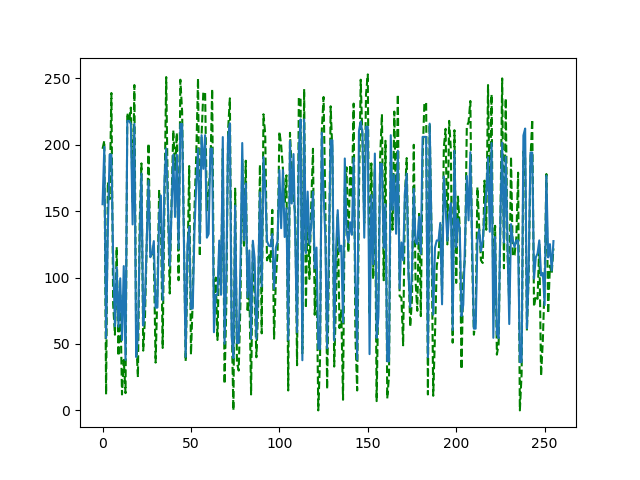

In [118]:
plt.plot(data_in, 'g--')
plt.plot(pred_reconstruction)

<IPython.core.display.Javascript object>


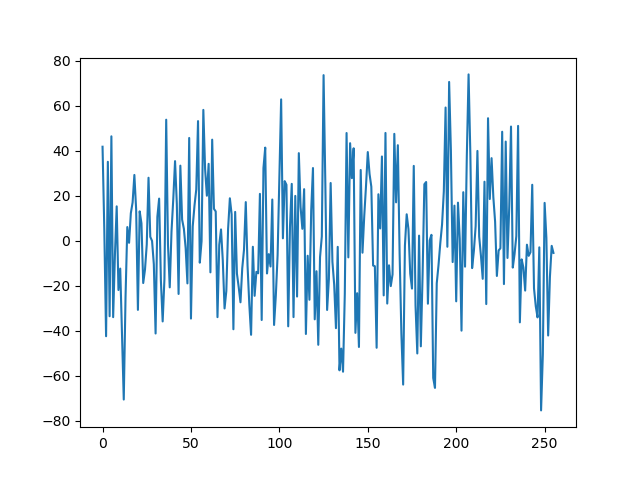

In [119]:
plt.plot(error)

In [121]:
MSE.mean()

23.528687499999997

In [125]:
print(causes.shape[0], np.arange(0, causes.shape[0]).shape)

64 (64,)


<IPython.core.display.Javascript object>


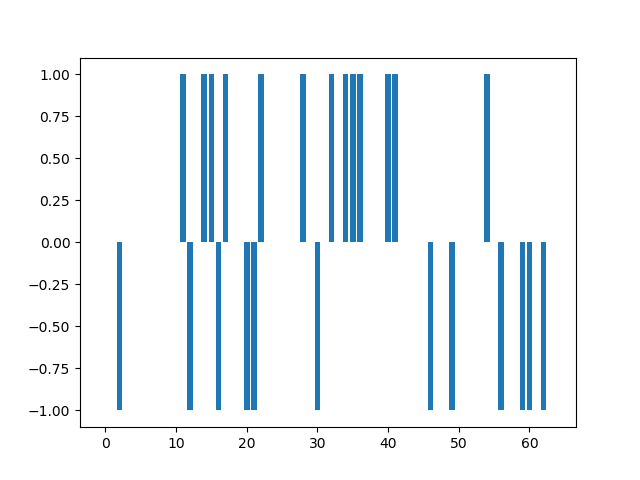

<BarContainer object of 64 artists>

In [126]:
plt.bar(np.arange(0, causes.shape[0]), causes.flatten())

In [127]:
cause_average = (r_buffer.sum(axis=1)/buf_length).reshape(-1,1); print(cause_average.T, cause_average.shape)

[[-0.574  0.505 -0.586  0.703  0.686 -0.564 -0.352 -0.396  0.353  0.541
   0.504  0.685 -0.401  0.538  0.619  0.54  -0.32   0.608 -0.692 -0.604
  -0.335 -0.579  0.49   0.302 -0.285  0.414 -0.585  0.54   0.712  0.287
  -0.638 -0.634  0.589  0.178  0.482  0.484  0.7    0.669 -0.573  0.45
   0.711  0.528  0.283  0.393  0.303  0.609 -0.687  0.103 -0.376 -0.527
  -0.445  0.379 -0.519 -0.064  0.489 -0.573 -0.575  0.492 -0.039 -0.716
  -0.517 -0.225 -0.381 -0.177]] (64, 1)


In [128]:
cause_average.T*128+128

array([[ 54.528, 192.64 ,  52.992, 217.984, 215.808,  55.808,  82.944,
         77.312, 173.184, 197.248, 192.512, 215.68 ,  76.672, 196.864,
        207.232, 197.12 ,  87.04 , 205.824,  39.424,  50.688,  85.12 ,
         53.888, 190.72 , 166.656,  91.52 , 180.992,  53.12 , 197.12 ,
        219.136, 164.736,  46.336,  46.848, 203.392, 150.784, 189.696,
        189.952, 217.6  , 213.632,  54.656, 185.6  , 219.008, 195.584,
        164.224, 178.304, 166.784, 205.952,  40.064, 141.184,  79.872,
         60.544,  71.04 , 176.512,  61.568, 119.808, 190.592,  54.656,
         54.4  , 190.976, 123.008,  36.352,  61.824,  99.2  ,  79.232,
        105.344]])

<IPython.core.display.Javascript object>


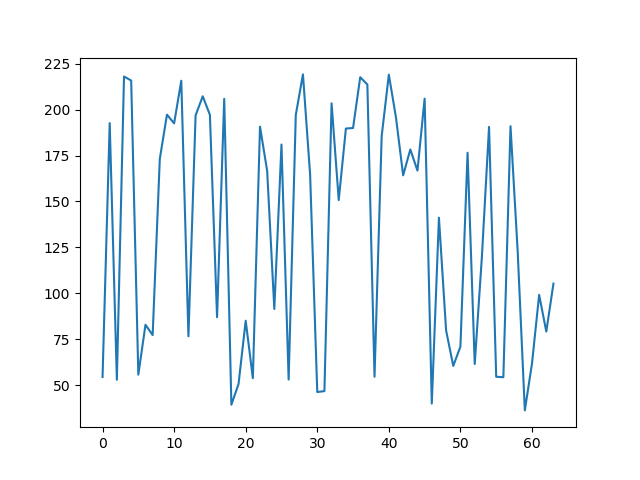

In [129]:
plt.plot(cause_average*128+128)

In [130]:
data_in.T

array([[197, 203,  12, 172, 159, 239,  80,  57, 123,  41,  87,  12,  38,
         13, 224, 217, 228, 157, 245,  54,  25, 141, 186,  45,  70, 126,
        201, 117, 118, 117,  36,  88, 166, 144,  47, 156, 251, 153,  88,
        156, 211, 181, 209,  98, 249, 225, 134,  37, 105, 184,  42,  83,
        152, 193, 250, 116, 207, 240, 239, 150, 167, 183, 242,  73, 100,
         53, 126,  92, 197,  20,  80, 211, 235,  68,   0, 167,  36,  30,
         82, 189, 124, 188,  74,  92,  12, 125,  90,  40,  78, 185,  58,
        223, 208, 113, 118, 112, 151,  54,  98, 121, 210, 200, 182, 157,
        177,  15, 209, 181, 159, 148,  34, 236, 234,  43, 242,  77, 158,
         99, 154, 197,  72, 109,   0,  39, 211, 236, 155,  16, 104, 229,
        194,  33,  81, 148,  62,  76,   8, 166, 183, 119, 185, 160, 231,
         56,  15, 163, 249, 203, 141, 238, 253,  72, 186,  99, 182,   7,
         91, 191, 223,  98, 203,   9,  26, 187, 136, 225, 150, 238,  86,
         85,  49, 162, 190, 108,  63,  84, 200,  98

To estimate the reconstruction, we need to:
* Sum and average the input and pred input buffers.

In [61]:
input_buffer[stage.ranges[10], 100]

array([ 1., -1.,  0.,  0.])

In [62]:
stage.vpus[0].pi.eigenvector

array([[0.60133255],
       [0.64726768],
       [0.45935125],
       [0.09187025]])

In [63]:
input_buffer.shape

(256, 1000)

In [64]:
input_signal.T

array([[ 0,  0,  0, -1,  0,  0,  1,  0, -1, -1, -1,  1, -1,  0,  1,  0,
         1, -1, -1,  0, -1, -1,  0,  0,  0,  1,  0,  1,  0,  0,  1,  0,
        -1,  1, -1, -1, -1,  0, -1,  0,  1, -1,  0,  0, -1,  0,  0,  1,
         0,  0,  0,  0, -1,  1, -1,  1,  0,  0,  0,  1,  0, -1, -1,  0,
         0,  1,  0,  0, -1,  1,  1, -1,  0,  0,  0,  0,  1,  1,  0,  1,
         0,  1,  0,  0, -1,  0,  1,  0, -1,  0,  0, -1,  1, -1,  1,  0,
         1,  0, -1,  0, -1,  1, -1, -1,  0,  0,  0, -1, -1,  0, -1,  0,
         0,  0,  1, -1, -1,  0,  1, -1,  0,  0, -1,  1,  0, -1,  1,  0,
         0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0, -1,  0, -1,  0,
         0,  1,  0,  0,  1,  0, -1, -1, -1,  0,  0,  1,  0,  0, -1,  0,
         1, -1,  0, -1,  0,  0, -1, -1, -1,  0,  1,  1, -1,  0, -1,  0,
         0,  1,  0,  0,  0,  0,  0, -1,  1,  1,  1,  0, -1,  0,  0,  0,
         1,  0, -1,  0,  0,  0,  1,  1,  0, -1,  1,  1, -1, -1,  1,  0,
         0,  0, -1,  1,  0,  1,  1, -1,  0,  0, -1,  1,  0,  0, 

In [65]:
causes.T

array([[-0.,  0.,  0.,  0.,  0., -0.,  1.,  1.,  0., -0.,  0.,  0.,  0.,
         0.,  1., -0.,  1.,  1.,  0.,  1.,  1.,  0., -0.,  0.,  0.,  0.,
        -0., -0.,  1.,  0.,  1.,  0.,  0.,  0., -0., -0.,  0.,  0.,  0.,
        -0.,  0., -1.,  0., -0.,  0., -0.,  1., -0.,  0.,  1.,  0.,  1.,
         1.,  1.,  1.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  0.]])

In [68]:
causes.sum()

17.0

In [69]:
r_buffer.sum()

14420.0

In [71]:
assert r_buffer.sum() < 256*500

In [76]:
(input_signal - pred_inputs).ravel()

array([ 0.,  0.,  0., -1.,  0.,  0.,  1.,  0., -1., -1., -1.,  1., -1.,
        0.,  1.,  0.,  1., -1., -1.,  0., -1., -1.,  0.,  0., -1.,  0.,
       -1.,  0.,  0., -1.,  0.,  0., -1.,  1., -1., -1., -1.,  0., -1.,
        0.,  1., -1.,  0.,  0., -1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
       -1.,  1., -1.,  1., -1., -1., -1.,  0.,  0., -1., -1.,  0.,  0.,
        0.,  0., -1., -1.,  0.,  0., -2.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0., -1.,  0., -1.,  0., -1.,  0.,  1.,  0., -1.,  0.,  0.,
       -1.,  1., -1.,  1.,  0.,  1.,  0., -1.,  0., -1.,  1., -1., -1.,
        0.,  0.,  0., -1., -1.,  0., -1.,  0., -1., -1.,  0., -1., -1.,
        0.,  1., -1., -1., -1., -1.,  0.,  0., -1.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0., -1.,  0., -1.,
        0.,  0.,  1.,  0.,  0.,  1.,  0., -1., -1., -1.,  0.,  0.,  1.,
        0.,  0., -1.,  0.,  1., -1.,  0., -1.,  1.,  1.,  0.,  0., -1.,
        0.,  1.,  1., -1.,  0., -1.,  0.,  0.,  1.,  0.,  0.,  0

<IPython.core.display.Javascript object>


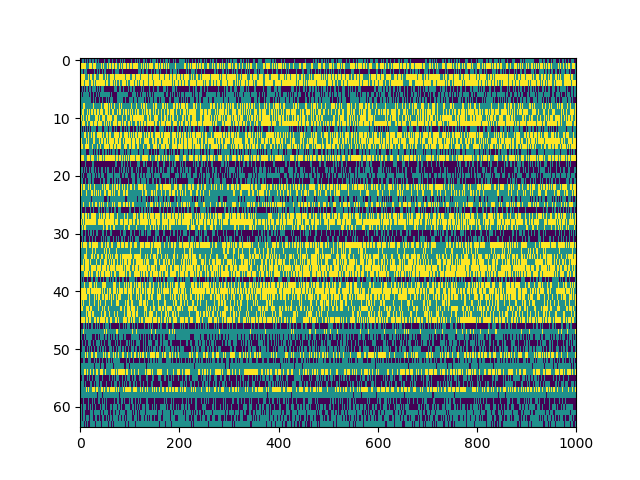

In [131]:
%matplotlib notebook
import matplotlib.pyplot as plt

plt.imshow(r_buffer, aspect='auto')

<IPython.core.display.Javascript object>


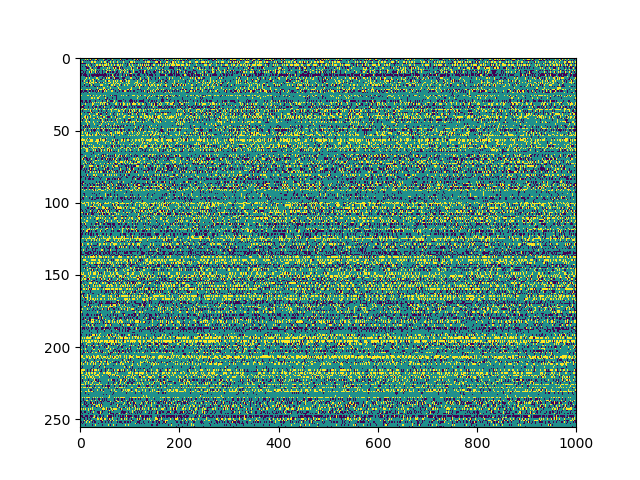

In [132]:
plt.imshow(residual_buffer, aspect='auto')

In [133]:
residual_buffer[:, 1].sum()

-5.0

In [170]:
4 % 1000

4

---
# Stage Test Wrapper

We can define a stage test wrapper, similar to our VPU wrapper.

In [171]:
class StageWrapper:
    """Wrapper for a stage to help testing."""
    
    def __init__(self, size=256, vec_len=4, buf_length=1000):
        """Initialise.
        
        Args:
            size - integer representing size of input data.
                Needs to be a power of vec_len.
            vec_len - integer representing the length of each
                VPU segment.
            buf_length - integer representing the number of iterations
                to buffer when testing.
        """
        # Testing a stage
        self.size = size
        self.vec_len = vec_len
        self.buf_length = buf_length
        self.stage = Stage(vec_len, size//vec_len)
        # Generate buffers for testing
        self.input_buffer = np.zeros(shape=(size, buf_length))
        self.pred_buffer = np.zeros(shape=(size, buf_length))
        self.r_buffer = np.zeros(shape=(size//vec_len, buf_length))
        self.residual_buffer = np.zeros(shape=(size, buf_length))
        self.count = 0
        
    def iterate(self, input_signal):
        """Iterate.
        
        Args:
            input_signal - numpy 1D array of length size.
        """
        # Process stage
        self.stage.update_cov(input_signal)
        causes = self.stage.forward(input_signal)
        pred_inputs = self.stage.backward(causes)
        i = self.count % self.buf_length
        self.input_buffer[:, i] = input_signal.ravel()
        self.pred_buffer[:, i] = pred_inputs.ravel()
        self.r_buffer[:, i] = causes.ravel()
        self.residual_buffer[:, i] = (input_signal - pred_inputs).ravel()
        self.count += 1

    def reconstruct(self, mean):
        """Reconstruct an input signal.
        
        Args:
            mean - 1D numpy array of length size containing signal mean.
        """
        pred_average = (self.pred_buffer.sum(axis=1)/self.buf_length).reshape(-1,1)
        pred_reconstruct = pred_average*mean
        return pred_reconstruct
    
    def error(self, data_in, mean):
        """Get error between original signal and prediction.
        
        Args:
            data_in - 1D numpy array of length size containing original signal.
            mean - 1D numpy array of length size containing signal mean.
        """
        pred_reconstruct = self.reconstruct(mean)+mean
        error = data_in - pred_reconstruct
        mse = np.abs(error).astype(np.uint8).mean()
        return error, mse
    
    def plot_buffers(self):
        """Plot buffer contents for quick check."""
        fig, axes = plt.subplots(2, 2, sharex=True)
        axes[0,0].set_title("Input Ternary Data")
        axes[0,0].imshow(self.input_buffer, aspect='auto')
        axes[1,0].set_title("Predicted Input")
        axes[1,0].imshow(self.pred_buffer, aspect='auto')
        axes[0,1].set_title("Residual Data")
        axes[0,1].imshow(self.residual_buffer, aspect='auto')
        axes[1,1].set_title("Causes")
        axes[1,1].imshow(self.r_buffer, aspect='auto')
        fig.subplots_adjust(hspace=0.2)
        plt.show()

[[-3.7440e+00 -1.8232e+01 -3.4232e+01 -6.9600e+00 -4.6392e+01  1.6576e+01
  -3.7864e+01 -8.4880e+00  2.5648e+01  1.9712e+01 -4.7488e+01  2.5336e+01
   1.1680e+00 -1.9520e+00  2.1168e+01  2.0168e+01 -1.4072e+01 -8.9280e+00
   2.6928e+01 -1.5280e+00 -3.5888e+01  6.1200e+00  1.9960e+01  1.3448e+01
  -4.8736e+01 -4.9488e+01  5.8272e+01 -2.7176e+01 -1.8720e+00 -4.7032e+01
  -1.0904e+01  2.8968e+01 -3.4976e+01 -3.9648e+01 -2.3800e+01  2.2976e+01
  -3.5264e+01 -2.0672e+01 -4.0000e+00 -9.0000e+00  8.9440e+00 -3.4960e+01
  -3.4576e+01 -2.2152e+01 -1.4128e+01  8.3760e+00 -1.0064e+01  3.5872e+01
   3.5552e+01  1.5200e-01 -1.8904e+01 -2.9520e+01  2.3232e+01  3.4232e+01
  -1.1360e+01 -9.1040e+00  2.6072e+01 -4.2936e+01  3.2072e+01  1.4088e+01
  -5.3600e-01  6.5360e+00  4.2488e+01  7.2616e+01 -5.0024e+01 -1.8976e+01
   3.6120e+01 -6.5840e+01 -9.8000e+00 -2.9392e+01 -2.6536e+01  3.2392e+01
   5.0240e+00 -3.1576e+01 -1.3576e+01 -6.7440e+00 -3.7632e+01  6.3840e+00
   6.8720e+00 -2.7952e+01 -1.0024e+01 

<IPython.core.display.Javascript object>


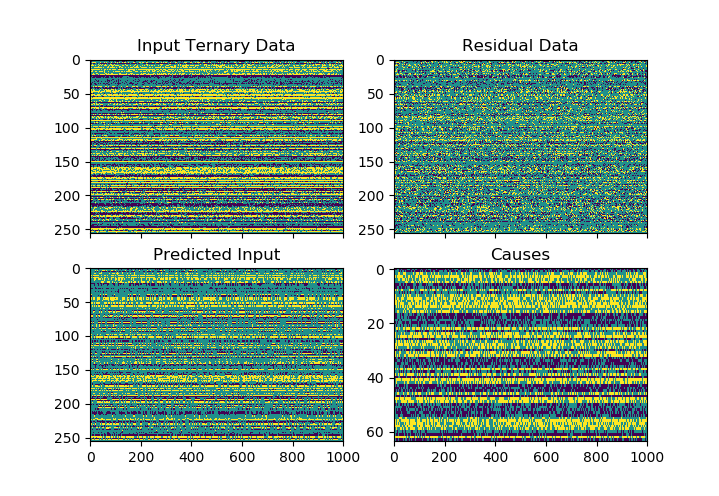

In [172]:
# Initialise stage wrapper
size = 256
vec_len = 4
buf_length = 1000
wrapper = StageWrapper(size, vec_len, buf_length)

# Generate fake data
data_in = np.random.randint(255, size=(size, 1))
mean = np.asarray([128]*size).reshape(-1, 1)

for i in range(0, buf_length):
    # Convert to ternary
    input_signal = signal_pre_processor(data_in, mean)
    wrapper.iterate(input_signal)
    
error, mse = wrapper.error(data_in, mean)
print(error.T, mse)
wrapper.plot_buffers()

The causes are a form of downsampled signal. These visualisations are nice.

Let's see what happens when we supply truly random input data - we can compare with above.

<IPython.core.display.Javascript object>


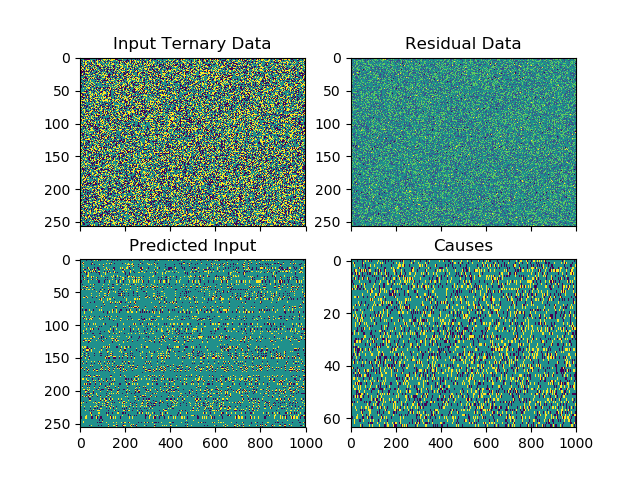

In [173]:
# Initialise stage wrapper
size = 256
vec_len = 4
buf_length = 1000
wrapper = StageWrapper(size, vec_len, buf_length)

data_in_buffer = np.zeros(shape=(size, buf_length))

# Generate fake data
mean = np.asarray([128]*size).reshape(-1, 1)

for i in range(0, buf_length):
    # Generate fake data
    data_in = np.random.randint(255, size=(size, 1))
    data_in_buffer[:, i] = data_in.ravel()
    # Convert to ternary
    input_signal = signal_pre_processor(data_in, mean)
    # Iterate stage
    wrapper.iterate(input_signal)
    
#error, mse = wrapper.error(data_in, mean)
#print(error.T, mse)
wrapper.plot_buffers()

Cool! It tries to find patterns in the noise, but the causes still end up as noise.

---
# Test Reconstruction Over Multiple Stages

For a vec_len of L we (should) need L stages to reconstruct the original signal.

So we take the stage residual and feed that to a next stage. We then sum up the predictions as before - we should get more accurate with each stage.

---
# Stack Development 

In [ ]:
class Stack:
    """Object to process a 1D sensor signal."""

    def __init__(self, sensor_len, vec_len):
        """Initialise sensor.

        Arg:
            sensor_len - length of input sensor vector - needs to be
                a power of vec_len.
            vec_len - length of vector for VPU.
        """
        self.sensor_len = sensor_len
        self.vec_len = vec_len
        # self.time_len = time_len
        # Variable to store time stages
        self.stages = list()
        num_stages = math.log(self.sensor_len, self.vec_len)
        self.num_stages = int(num_stages)
        self.build_stages()

    def generate_stage(self, stage_len):
        """Generate a stage.

        Arg:
            stage_len - integer number of stages.
        """
        return Stage(self.vec_len, stage_len)

    def build_stages(self):
        """Build a set of stages."""
        self.stages = [
            self.generate_stage(
                int(self.sensor_len / self.vec_len**(i+1))
            )
            for i in range(0, self.num_stages)
        ]

    def forward(self, sw_residuals):
        """Forward pass through the stack.

        Args:
            sw_residuals: weighted residuals from switch, list of arrays.
        """
        pass

    def backward(self, stack_feedback):
        """Backward pass through the stack.

        Args:
            stack_feedback: feedback for last stage, scalar.
        """
        pass

    def update_cov(self, orig_input):
        """Update the covariance matrices.

        Run after computing the FF outputs in a forward pass.

        Args:
            orig_input: original un-switch-filtered input as array.
        """
        # for stage in stages:
        pass


    def iterate(self, orig_input, sw_residuals, stack_feedback):
        """High level processing loop.

        We have to implement the stack and switch together. The sw_residuals
        require output from the for loop below. The switch has a set
        of stages equal to the stack, each stage having a comparison
        and a weighting.

        Args:
            orig_input: original un-switch-filtered input, list of
                arrays.
            sw_residuals: weighted residuals from switch, list of arrays.
            stack_feedback: feedback for last stage, scalar.

        Returns:
            ff_outputs: FF outputs from each stage.
            predictions: FB outputs from each stage.

        """
        # How do we get current prediction when we haven't iterated?
        # Get prediction from last time stamp?
        # Or do a forward pass first, then do a backard pass?
        for i in range(0, self.num_stages-1):
            # Get predicted inputs for current stage
            prediction = self.stages[i].get_pred_inputs()
            # Compute FF input by adding residuals to prediction
            stage_ff_input = sw_residuals[i] + prediction
            # Get FB input from next stage
            stage_fb_input = self.stages[i+1].get_pred_inputs()
            # Iterate current FF stage
            feedforward, _ = self.stages[i].iterate(
                orig_inputs[i],
                stage_ff_input,
                stage_fb_input
            )
        # Then feedforward to last stage with stack_feedback
        feedforward, _ = self.stages[-1].iterate(
            orig_inputs[-1],
            feedforward,
            stack_feedback
        )
        # Return r_out for last stage
        return feedforward

    def get_causes(self):
        """Return causes as a list of arrays."""
        return [
            stage.get_causes() for stage in self.stages
        ]

    def get_pred_inputs(self):
        """Return predicted inputs as a list of arrays."""
        return [
            stage.get_pred_inputs() for stage in self.stages
        ]

    def get_outputs(self):
        """Return the outputs for the stack."""
        cause_output = self.stages[-1].get_causes()
        prediction_output = self.stages[0].get_pred_inputs()
        return cause_output, prediction_output

    def get_lengths(self):
        """Return the vector lengths of the causes and predicted inputs."""
        causes = self.get_causes()
        pred_inputs = self.get_pred_inputs()
        cause_lengths = [cause.shape[0] for cause in causes]
        pred_lengths = [pred.shape[0] for pred in pred_inputs]
        return cause_lengths, pred_lengths
